In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib as mpl

import numpy as np

import time
import random
import pylab
import time, sys

from IPython.display import clear_output
from random import randrange
from hrr import *

seed = random.randint(1,1000000000)
np.random.seed(775118366)
random.seed(775118366)

In [2]:
# Number of training cycles
episodes = 50000

# Hrr parameters
hrr_length = 6144
normalized = True

# How many steps to take before quiting
steps_till_quit = 100

signals = ["R", "G", "B"]
goals = [5, 10, 15]

# Maze parameters
size_of_maze = 20
non_obs_task_switch_rate = 500
num_obs_tasks = len(signals)

# Arguments for neural network
input_size = hrr_length
output_size = 1
discount = 0.9
alpha = 0.1

# Reward for temporal difference learning
reward_bad = -1
reward_good = 0

# Expolration rate
e_soft = 0.0001
rand_on = 1

# Eligibility trace
eligibility = np.zeros(hrr_length)

# Eligibility trace rate
eli_lambda = 0.01

# Neural network
weights = hrr(hrr_length, normalized)
bias = 1

rand_on = 1
debug = False

percent_check = 9

In [3]:
def get_moves(state, size_of_maze):
    if(state == 0):
        return size_of_maze - 1, 1
    elif(state == size_of_maze - 1):
        return size_of_maze - 2, 0
    else:
        return state - 1, state + 1

In [4]:
ltm = LTM(hrr_length, normalized)

In [5]:
ltm.print()

I [1. 0. 0. ... 0. 0. 0.]


In [6]:
def update_progress(progress, episode):
    bar_length = 50
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Episode {0}, Progress: [{1}] {2:.1f}%".format(episode, "=" * block + "." * (bar_length - block), progress * 100)
    print(text)

In [7]:
def context_policy_negative(atr):
    return (atr + 1)%num_non_obs_tasks

def context_policy_positive(state):
    val = -9999
    temp = -9999
    for atr in range(0, num_non_obs_tasks):
        encode_str = build_hrr_string(state, atr)
        temp = np.dot(weights, ltm.encode(encode_str)) + bias
        if temp > val:
            val = temp
            s_atr = atr
    return s_atr


def build_hrr_string(wm, signal, state):
    if wm == "I" and signal == "I":
        return "State:" + str(state)
    elif wm == "I":
        return "Signal:" + str(signal) + "*" + "State:" + str(state)
    elif signal == "I":
        return "WM:" + str(wm) + "*" + "State:" + str(state)
    else:
        return "WM:" + str(wm) + "*" + "Signal:" + str(signal) + "*" + "State:" + str(state)
    
def move_policy(goal, moves, wms, signals, rand_on):
    
    val = -9999
    temp = -9999
    
    for move in moves:
        for wm in list(dict.fromkeys(wms + ["I"])):
            for signal in list(dict.fromkeys(signals + ["I"])):
                if move == goal:
                    encode_str = build_hrr_string(wm, signal, str(move) + "*rewardTkn")
                else:
                    encode_str = build_hrr_string(wm, signal, str(move))
                if (debug):
                    print(encode_str)
                temp = np.dot(weights, ltm.encode(encode_str)) + bias
                if debug:
                    if signal != "I":
                        print("Move: {0}, WM: {1}, Signal: {2}In, Value: {3}".format(move, wm, signal, temp))
                    else:
                        print("Move: {0}, WM: {1}, Signal: {2}, Value: {3}".format(move, wm, signal, temp))
                if temp > val:
                    val = temp
                    s_move = move
                    if signal != "I":
                        s_wm = signal + "In"
                    else:
                        s_wm = wm
            
    # Random move
    if(np.random.random_sample() < e_soft) and rand_on:
        if(debug):
            print("RANDOM MOVE")
        return (np.random.choice(moves), wm, 1)
    
    return (s_move, s_wm, 0)


def logmod(x):
    return np.sign(x)*np.log(abs(x)+1)

def get_opt_steps(start, goal, size_of_maze):
    opt = abs(goal - start)
    if opt > size_of_maze / 2:
        opt = size_of_maze - opt
    return opt

In [8]:
t0 = time.time()
opt_count = 0
debug2 = False
step_store = []
current_wm = "I"

In [9]:
for x in range(episodes):
        
    current_state = random.randint(0, size_of_maze - 1)
    start = current_state
    current_signal = np.random.choice(signals)
       
    goal = goals[signals.index(current_signal)]

    steps = 0
    opt_steps = get_opt_steps(current_state, goal, size_of_maze)

    # Reset trace
    eligibility *= 0.0

    if x > ((episodes*percent_check) / 10) :
        debug2 = True
        rand_on = 0
        alpha = 0.01
    
    if debug:
        print("Goal: {0}, Signal: {1}, Non_Observable: {2}".format(goal, current_signal, non_obs))
        
    episode_memory = []
    for y in range(steps_till_quit):
        if (current_state == goal):
            encode_str = build_hrr_string(current_wm, current_signal, str(current_state) + "*rewardTkn")
            goal_hrr = ltm.encode(encode_str)
            goal_value = np.dot(weights, goal_hrr) + bias
            episode_memory += [[current_state, goal_value, goal]]

            error = reward_good - goal_value
            eligibility *= eli_lambda
            eligibility = eligibility + goal_hrr
            weights = np.add(weights, (alpha * logmod(error) * eligibility))
            
            if(debug):
                print("In goal with value {0}".format(goal_value))
            
            break
            
        # Store info about previous state      
        previous_wm = current_wm
        previous_signal = current_signal
        previous_state = current_state
        
        
        if debug:
            print("Previous WM:, {0}, Signal:, {1}, State, {2}".format(previous_wm, previous_signal, previous_state))
        
        encode_str = build_hrr_string(previous_wm, previous_signal, previous_state)
        previous_state_hrr = ltm.encode(encode_str)
        previous_value = np.dot(weights, previous_state_hrr) + bias
        
        
        if debug:
            print("Started with state: {0}, State Value: {1}, WM: {2}".format(previous_state, previous_value, previous_wm))
            
        current_signal = "I"
        left, right = get_moves(previous_state, size_of_maze)
        if previous_signal != "I":
            previous_signal += "In"

        # Make the move
        move, wm, random_move = move_policy(goal, [left, right], [previous_wm, previous_signal], [current_signal], rand_on)
        steps += 1
        
        current_wm = wm
        current_state = move
        
        if random_move:
            eligibility *= 0.0
            
        if(debug):
            print("Moves {0}, taken {1}".format([left, right], move))
            
        if debug:
            print("Current WM {0}, Current Signal {1}, Current state {2}".format(current_wm, current_signal, current_state))
            
        if current_state == goal:
            encode_str = build_hrr_string(current_wm, current_signal, str(current_state) + "*rewardTkn")     
            if debug:
                print("In goal: WM: {1}".format(current_wm))
        else:
            encode_str = build_hrr_string(current_wm, current_signal, current_state)
            
        current_state_hrr = ltm.encode(encode_str)
        current_value = np.dot(weights, current_state_hrr) + bias
        
        sarsa_error = (reward_bad + discount * current_value) - previous_value
        eligibility *= eli_lambda
        eligibility = eligibility + previous_state_hrr
        weights = np.add(weights, (alpha * logmod(sarsa_error) * eligibility))
        
        if debug:
            input("")
            
    if debug2:
        if current_state == goal:
            step_store += [steps - opt_steps]
        else:
            step_store += [steps]
            
    update_progress(x / episodes, x)
    
update_progress(1, episodes)

Episode 50000, Progress: [==================================================] 100.0%


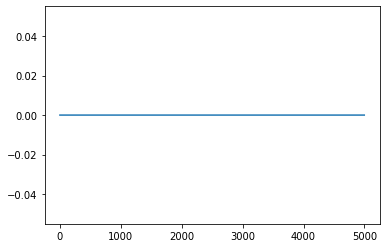

100.0


In [10]:
plt.plot(step_store)
plt.show()
accuracy = (len(step_store)-np.count_nonzero(step_store))*100.0 / len(step_store)
print(accuracy)

In [11]:
# fig, axes = plt.subplots(nrows=2, ncols=num_obs_tasks+1)
# fig.set_figwidth(20)
# fig.set_figheight(20)

# y_for_rwd = 0
# y_for_no_rwd = 0

# for wm in list(dict.fromkeys([signal + "In" if signal != "I" else signal for signal in signals] + ["I"])):
#     position = np.arange(size_of_maze)
#     value = np.zeros(size_of_maze)
#     for signal in signals + ["I"]:
#         lab = "WM:" + wm + "*Signal:" + signal + "*rewardTkn"
#         for state in range(size_of_maze):
#             encode_str = build_hrr_string(wm, signal, str(state) + "*rewardTkn")
#             value[state] = np.dot(weights, ltm.encode(encode_str)) + bias
#         axes[0,y_for_rwd].title.set_text(wm + " with rewardTkn")
#         axes[0,y_for_rwd].plot(position, value, label=lab)
#         axes[0,y_for_rwd].legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
#               fancybox=True, shadow=True, ncol=1, prop={'size': 10})
#     y_for_rwd += 1
        
#     y = x + 1
#     value = np.zeros(size_of_maze)
#     for signal in list(dict.fromkeys(signals + ["I"])):
#         lab = "WM:" + wm + "*Signal:" + signal
#         for state in range(size_of_maze):
#             encode_str = build_hrr_string(wm, signal, str(state))
#             value[state] = np.dot(weights, ltm.encode(encode_str)) + bias
#         axes[1,y_for_no_rwd].title.set_text(wm)
#         axes[1,y_for_no_rwd].plot(position, value, label=lab)
#         axes[1,y_for_no_rwd].legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
#               fancybox=True, shadow=True, ncol=1, prop={'size': 10})
#     y_for_no_rwd += 1

# plt.suptitle("{0} Observable tasks with goals: {1}".format(num_obs_tasks, goals), fontsize=30)
# plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# plt.show()

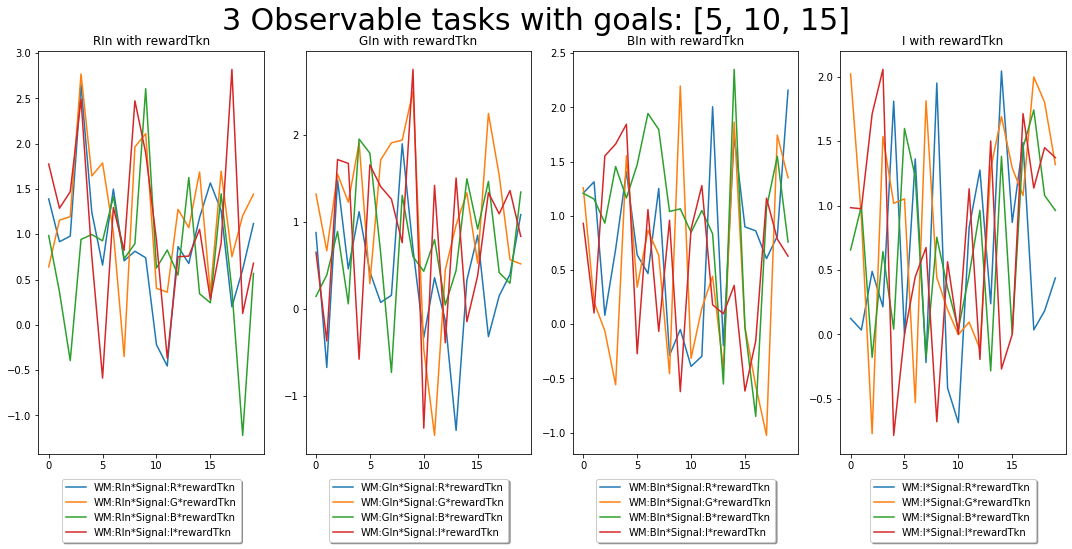

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=num_obs_tasks+1)
fig.set_figwidth(15)
fig.set_figheight(8)

y_for_rwd = 0
y_for_no_rwd = 0

for wm in list(dict.fromkeys([signal + "In" if signal != "I" else signal for signal in signals] + ["I"])):
    position = np.arange(size_of_maze)
    value = np.zeros(size_of_maze)
    for signal in signals + ["I"]:
        lab = "WM:" + wm + "*Signal:" + signal + "*rewardTkn"
        for state in range(size_of_maze):
            encode_str = build_hrr_string(wm, signal, str(state) + "*rewardTkn")
            value[state] = np.dot(weights, ltm.encode(encode_str)) + bias
        axes[y_for_rwd].title.set_text(wm + " with rewardTkn")
        axes[y_for_rwd].plot(position, value, label=lab)
        axes[y_for_rwd].legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
              fancybox=True, shadow=True, ncol=1, prop={'size': 10})
    y_for_rwd += 1

plt.suptitle("{0} Observable tasks with goals: {1}".format(num_obs_tasks, goals), fontsize=30)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('test.png')
plt.show()